In [1]:
# Import all the libraries 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import requests
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [11]:
# Read Wiki Page
wikiPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
wikiPage.status_code
#Load the page using BeautifulSoup
soup = BeautifulSoup(wikiPage.content, 'html.parser')
# load the table with zipcodes
ziptext = soup.find_all(class_="wikitable sortable")
# get all table cells
tableData = ziptext[0].find_all("td")

In [12]:
# load the table in a Pandas dataframe
columnName=['PostalCode','Borough','Neighborhood']
notAssignedStr = 'Not assigned'
zip_df = pd.DataFrame(columns=columnName)
prevPostalCodeStr=""
prevboroughStr=""
prevneighStr=""
postalCodeStr=""
for x in range(0,len(tableData),3):
    #print(tableData[x+1].get_text()+":" + tableData[x+2].get_text() + ":" + tableData[x+3].get_text() )
    if ( tableData[x+1].get_text() != notAssignedStr ):      
        postalCodeStr= tableData[x].get_text()
        boroughStr=tableData[x+1].get_text()
        neighStr=tableData[x+2].get_text().replace("\n","")
        #   if prev post code is same do not append , move to next row 
        if (prevPostalCodeStr == postalCodeStr):
            
            # Add Borough name if not same with the same postal code
            if (prevboroughStr != boroughStr):
                 prevboroughStr = prevboroughStr + "," + boroughStr
            # Add Neighbour name if not same with the same postal code
            if (prevneighStr != neighStr):
                prevneighStr = prevneighStr + "," + neighStr
        else:   
            # first time
            if (prevPostalCodeStr==""):
                prevboroughStr=tableData[x+1].get_text()
                prevneighStr=tableData[x+2].get_text().replace("\n","")
                prevPostalCodeStr=postalCodeStr
                
            row_df=pd.DataFrame({'PostalCode':[prevPostalCodeStr],'Borough':[prevboroughStr],'Neighborhood': [prevneighStr]})
            #print("Adding",row_df)
            zip_df = zip_df.append(row_df,ignore_index=True)
            prevboroughStr=tableData[x+1].get_text()
            prevneighStr=tableData[x+2].get_text().replace("\n","")
            prevPostalCodeStr=postalCodeStr

    # Add last row even if postale code is same
   
    if ((prevPostalCodeStr == postalCodeStr) and (x  == len(tableData) -3)):
        row_df=pd.DataFrame({'PostalCode':[prevPostalCodeStr],'Borough':[prevboroughStr],'Neighborhood': [prevneighStr]})
        zip_df = zip_df.append(row_df,ignore_index=True)
toronto_data = zip_df

In [13]:
# Read the Coordinates file and add the columns to the toronto data frame
coord_df=pd.read_csv("http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv")
coord_df.set_index(["Postal Code"],inplace=True)
toronto_data.set_index(["PostalCode"],inplace=True)
toronto_data=toronto_data.join(coord_df)
toronto_data.reset_index(inplace=True)
toronto_data.rename(columns={'index':'PostalCode'},inplace=True)

In [14]:
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
# Get Latitude and Longitude for Toronto
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [16]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [17]:
#Four Square ID 
CLIENT_ID = 'Q10S2OBQ4EIYOQ2OCFDMZY0N41GXUWSPCG1WUTMQXFBVE30G' # your Foursquare ID
CLIENT_SECRET = 'DKIZCLLOJHE3IXVGPVDQDY5HT2OHXPQNL1HXL1H25SJI5ALW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Q10S2OBQ4EIYOQ2OCFDMZY0N41GXUWSPCG1WUTMQXFBVE30G
CLIENT_SECRET:DKIZCLLOJHE3IXVGPVDQDY5HT2OHXPQNL1HXL1H25SJI5ALW


In [18]:
LIMIT = 100
def getNearbyVenuesCountByCategory(name, latitude, longitude,categoryId, radius=500):
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT,
            categoryId)
    resultCnt = 0
    response = requests.get(url).json()
    try:
        resultCnt= response["response"]["totalResults"]
    except:
        print(response) 
    
    return resultCnt

In [19]:
# load toronto venues
callcount=0
#define categories to compare the different neighbourhood 
categories = {"Arts&Entertainment":"4d4b7104d754a06370d81259","School":"4bf58dd8d48988d13b941735","Restaurant":"4d4b7105d754a06374d81259",
              "Nightlife Spot":"4d4b7105d754a06376d81259","Parks&Recreation":"4d4b7105d754a06377d81259",
              "ProfessionalServices":"4d4b7105d754a06375d81259","Office":"4bf58dd8d48988d124941735",
              "Place of Worship":"4bf58dd8d48988d131941735","Shopping":"4d4b7105d754a06378d81259","Grocery":"4bf58dd8d48988d1f9941735"}
for catName,catId in categories.items():
    #print("catName:",catName,"CatId:",catId)
    cat_df = pd.DataFrame(columns=[catName])
    for name,lat,long in zip(toronto_data['Neighborhood'],toronto_data['Latitude'],toronto_data['Longitude']):
        resultcnt = getNearbyVenuesCountByCategory(name=name,latitude=lat,longitude=longitude,categoryId=catId)
        cat_df = cat_df.append({catName:resultcnt},ignore_index=True)
        #print("callcount:",callcount,"resultcnt:",resultcnt)
        #print(cat_df.head())
        callcount = callcount+1
    toronto_data[catName]=cat_df

print("callcount:",callcount)
toronto_data.head()


callcount: 1040


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,1,4,0,2,4,1,1,5,1
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2,0,2,0,2,5,1,3,3,0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,2,0,4,0,5,4,7,4,4,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,2,14,1,4,7,0,1,46,4
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,2,2,0,4,4,0,0,33,1


In [25]:
# convert all the columns except neighbourhood to float
toronto_onehot = toronto_data[toronto_data.columns[5:]].astype('float32')

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
0,"Rouge,Malvern",0.0,1.0,4.0,0.0,2.0,4.0,1.0,1.0,5.0,1.0
1,"Highland Creek,Rouge Hill,Port Union",2.0,0.0,2.0,0.0,2.0,5.0,1.0,3.0,3.0,0.0
2,"Guildwood,Morningside,West Hill",2.0,0.0,4.0,0.0,5.0,4.0,7.0,4.0,4.0,0.0
3,Woburn,3.0,2.0,14.0,1.0,4.0,7.0,0.0,1.0,46.0,4.0
4,Cedarbrae,1.0,2.0,2.0,0.0,4.0,4.0,0.0,0.0,33.0,1.0


In [26]:
#check data types
toronto_onehot.dtypes

Neighborhood             object
Arts&Entertainment      float32
School                  float32
Restaurant              float32
Nightlife Spot          float32
Parks&Recreation        float32
ProfessionalServices    float32
Office                  float32
Place of Worship        float32
Shopping                float32
Grocery                 float32
dtype: object

In [27]:
# Use Min Max Scaler to scale all the coumns , At this point potentially a weight can also be applied to the columns
toronto_grouped = toronto_onehot.drop('Neighborhood',1)
toronto_grouped.head()
from sklearn.preprocessing import MinMaxScaler
toronto_grouped_clustering = pd.DataFrame(MinMaxScaler().fit_transform(toronto_grouped),columns=toronto_grouped.columns)
toronto_grouped_clustering.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
0,0.000000,0.083333,0.037383,0.000000,0.044444,0.036697,0.011236,0.142857,0.043478,0.043478
1,0.051282,0.000000,0.018692,0.000000,0.044444,0.045872,0.011236,0.428571,0.026087,0.000000
2,0.051282,0.000000,0.037383,0.000000,0.111111,0.036697,0.078652,0.571429,0.034783,0.000000
3,0.076923,0.166667,0.130841,0.016393,0.088889,0.064220,0.000000,0.142857,0.400000,0.173913
4,0.025641,0.166667,0.018692,0.000000,0.088889,0.036697,0.000000,0.000000,0.286957,0.043478


In [28]:
# Define weigtage 
# Arts&Entertainment:10,School:10,Restaurant:10,Nightlife Spot:5,Parks&Recreation:10,ProfessionalServices:5,Office:5,Place of Worship:10,Shopping:5,Grocery:10}

weightSer = [1,10,10,1,10,5,1,10,5,10]
toronto_weigthed_clustering = toronto_grouped_clustering * weightSer
toronto_weigthed_clustering.head()

,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
0,0.000000,0.833333,0.373832,0.000000,0.444444,0.183486,0.011236,1.428571,0.217391,0.434783
1,0.051282,0.000000,0.186916,0.000000,0.444444,0.229358,0.011236,4.285714,0.130435,0.000000
2,0.051282,0.000000,0.373832,0.000000,1.111111,0.183486,0.078652,5.714286,0.173913,0.000000
3,0.076923,1.666667,1.308411,0.016393,0.888889,0.321101,0.000000,1.428571,2.000000,1.739130
4,0.025641,1.666667,0.186916,0.000000,0.888889,0.183486,0.000000,0.000000,1.434783,0.434783


/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


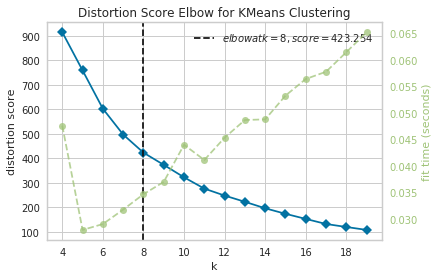

In [29]:
# Use KElbowVisualizer to find the best value of cluster
model=KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,20))
visualizer.fit(toronto_weigthed_clustering)
visualizer.show()

In [30]:
#set number of clusters to 8
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_weigthed_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
print(kmeans.labels_)

[3 0 0 3 3 3 3 0 3 0 0 0 3 0 3 3 3 3 0 0 0 3 3 0 3 0 0 3 3 0 3 3 3 3 0 3 7
 3 0 7 7 3 3 4 1 3 3 3 7 0 0 3 4 6 1 1 2 5 1 2 5 2 2 3 3 3 1 6 1 3 2 2 3 0
 3 0 4 4 2 5 3 0 1 6 2 2 6 5 6 3 3 1 3 3 4 2 5 3 3 7 3 0 3 7]


In [32]:
# add clustering labels
#toronto_data.drop(columns=['Cluster Labels'],inplace=True)
toronto_data.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood'], toronto_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if (np.isnan(cluster)):
        cluster=0
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
toronto_data.sort_values(by=['School'],ascending=False)

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
66,1,M5R,Central Toronto,"The Annex,North Midtown,Yorkville",43.672710,-79.405678,11,12,59,15,24,69,70,4,100,15
82,1,M6N,York,"The Junction North,Runnymede",43.673185,-79.487262,11,11,46,12,23,66,76,3,104,13
58,1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,5,11,64,17,24,84,56,2,61,22
59,2,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,31,11,88,44,34,107,68,1,61,10
71,2,M5X,Downtown Toronto,"First Canadian Place,Underground city",43.648429,-79.382280,39,11,99,56,37,107,85,1,82,12
78,2,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750,38,11,102,60,40,108,88,1,94,13
62,2,M5L,Downtown Toronto,"Commerce Court,Victoria Hotel",43.648198,-79.379817,39,11,100,59,39,109,87,2,91,12
61,2,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,37,10,105,61,42,105,89,1,97,13
55,1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,6,10,60,17,24,87,62,3,62,23
56,2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,28,10,73,38,34,92,58,3,59,9


In [37]:
# The neighborhoods with max number of school is in Cluster 1. Lets see 5 such neighborhoods

#toronto_data.head()
toronto_data[toronto_data['Cluster Labels']==1].head(5)

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
44,1,M4M,East Toronto,Studio District,43.659526,-79.340923,3,6,58,16,23,84,45,3,70,19
54,1,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,21,9,41,13,30,76,51,4,47,13
55,1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,6,10,60,17,24,87,62,3,62,23
58,1,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,5,11,64,17,24,84,56,2,61,22
66,1,M5R,Central Toronto,"The Annex,North Midtown,Yorkville",43.672710,-79.405678,11,12,59,15,24,69,70,4,100,15


In [38]:
# The neighborhoods with least number of schools are in Cluster 0
toronto_data[toronto_data['Cluster Labels']==0].head(5)

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude,Arts&Entertainment,School,Restaurant,Nightlife Spot,Parks&Recreation,ProfessionalServices,Office,Place of Worship,Shopping,Grocery
1,0,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2,0,2,0,2,5,1,3,3,0
2,0,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,2,0,4,0,5,4,7,4,4,0
7,0,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,3,2,10,3,3,10,3,3,7,1
9,0,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,1,0,2,0,4,1,1,2,5,0
10,0,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,1,0,0,0,1,4,0,4,0,0
